# Visualizing the forecastings

In [19]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from code.sirds.sirds_model_visualization import get_sirds, get_sirds_extras, show_performance, plot_result, \
    show_performance_single, plot_result_single

## Reading data

In [20]:
df = pd.read_csv('../../data/input/df_ts_epidemic_episodes.csv', index_col=0)
df.DATA = pd.to_datetime(df.DATA)

In [21]:
df.columns

Index(['DATA', 'CODIGO_MUNICIPIO_6', 'NOVOS_CASOS_SRAG', 'OBITOS_NOVOS',
       'OBITOS', 'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS', 'TAXA_OBITOS_NOVOS',
       'TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS', 'TAXA_OBITOS', 'casosNovos',
       'casosAcumulado', 'CASOS_NOVOS_MEDIA_MOVEL_7_DIAS', 'MUNICIPIO',
       'SIGLA_ESTADO', 'ESTADO', 'REGIAO', 'POPULACAO_2022',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.025',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIANA',
       'NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.975',
       'NUMERO_REPRODUCAO_EFETIVO_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.025',
       'NUMERO_REPRODUCAO_EFETIVO_MEDIANA',
       'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.975',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL

In [22]:
df = df.sort_values(by=['CODIGO_MUNICIPIO_6', 'DATA'])
df['TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS'] = df.CASOS_NOVOS_MEDIA_MOVEL_7_DIAS / df.POPULACAO_2022 * 100000

In [23]:
df_results = pd.read_csv('../sirds/data/estimation_results.csv')
df_results['max_date_to_fit'] = pd.to_datetime(df_results['max_date_to_fit']) 

In [24]:
df_results = df_results.sort_values(['max_date_to_fit','municipality'])

In [25]:
FORECASTING_HORIZON = 84

In [26]:
df_estimated_parameters = pd.read_csv('data/df_estimated_parameters.csv')
df_estimated_parameters['max_date_to_fit'] = pd.to_datetime(df_estimated_parameters['max_date_to_fit']) 

In [27]:
len(df_estimated_parameters)

7340

In [28]:
sum(df_estimated_parameters['estimated_contact_rate'].isna())

4880

In [29]:
sum(df_estimated_parameters['estimated_contact_rate']*8>=1)

2458

## Presenting results

In [30]:
df_estimated_parameters.columns

Index(['municipality_id', 'municipality', 'max_date_to_fit', 'estimation',
       'estimated_fatality', 'estimated_contact_rate'],
      dtype='object')

estimated_contact_rate:  None
Porto Alegre


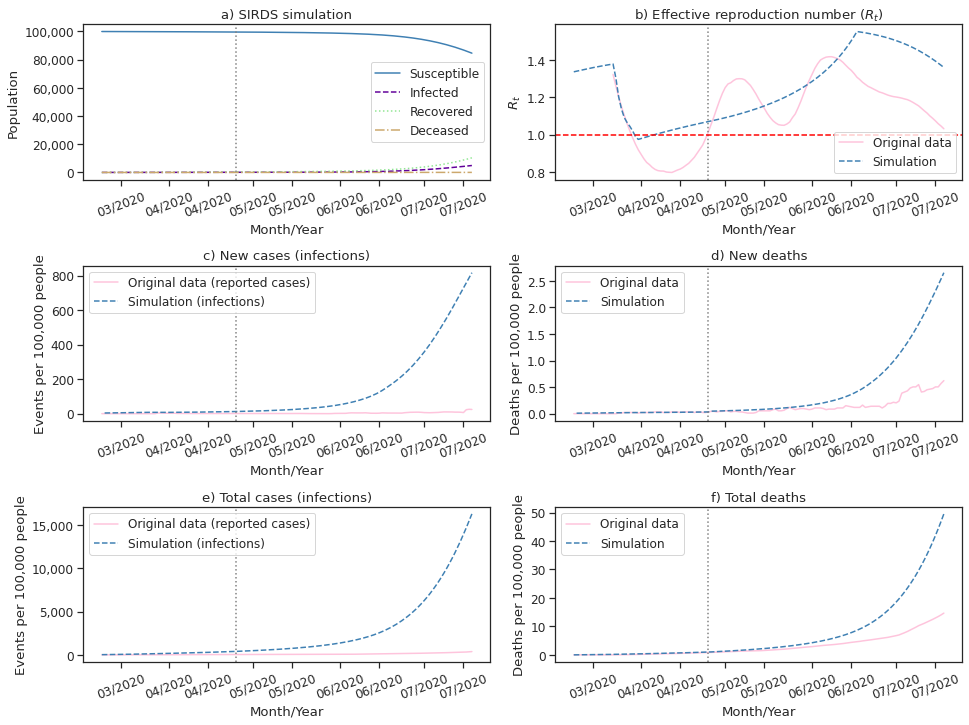

estimated_contact_rate:  None
Porto Alegre


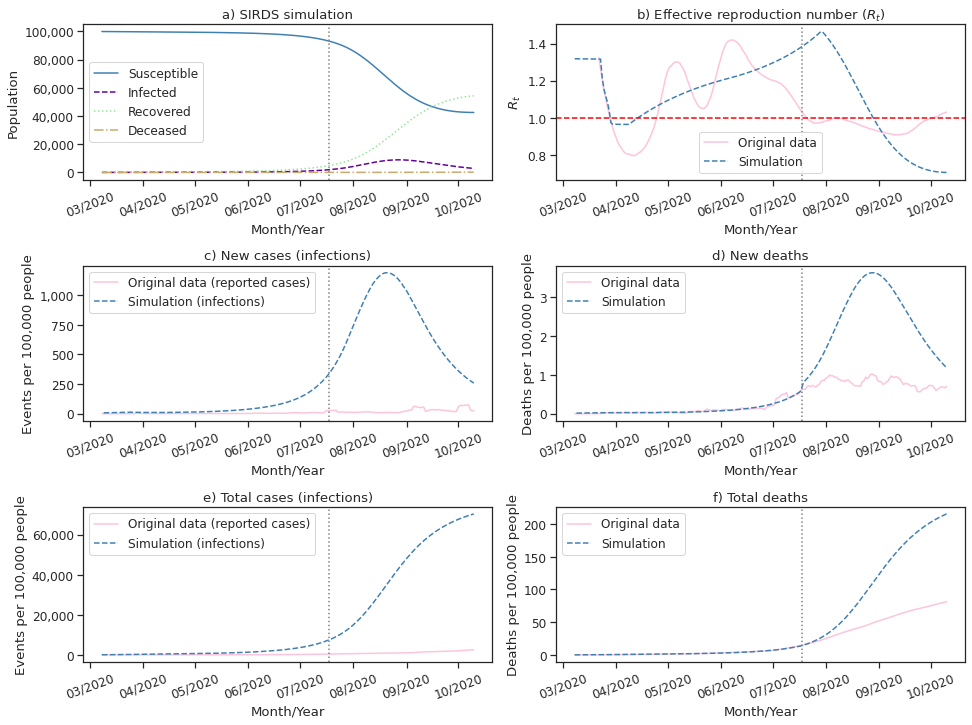

estimated_contact_rate:  None
Porto Alegre


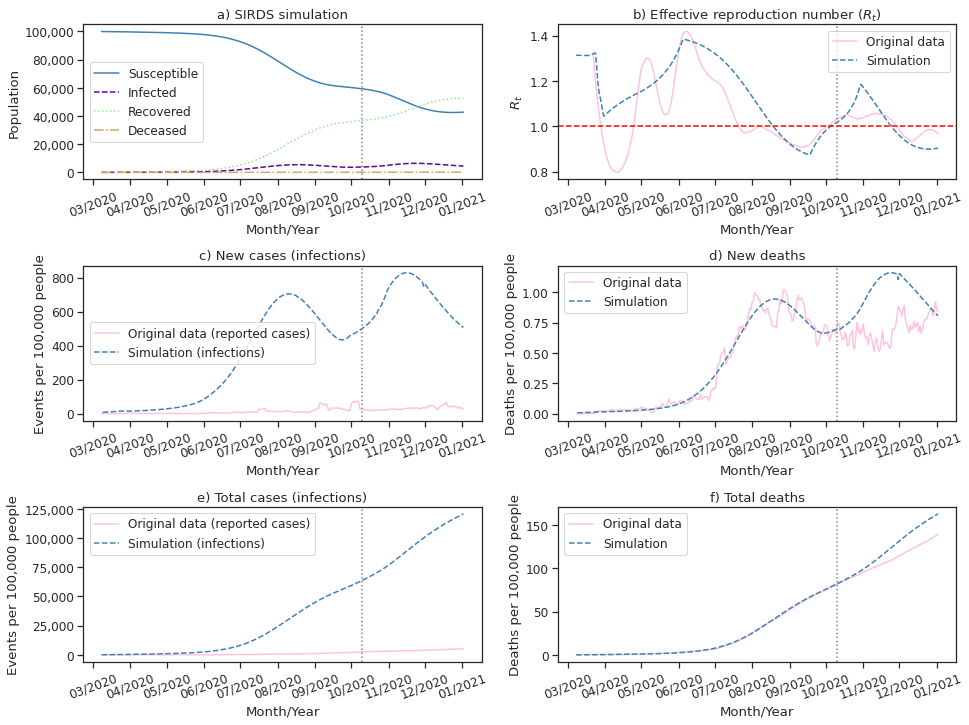

estimated_contact_rate:  0.224291767398608
Porto Alegre


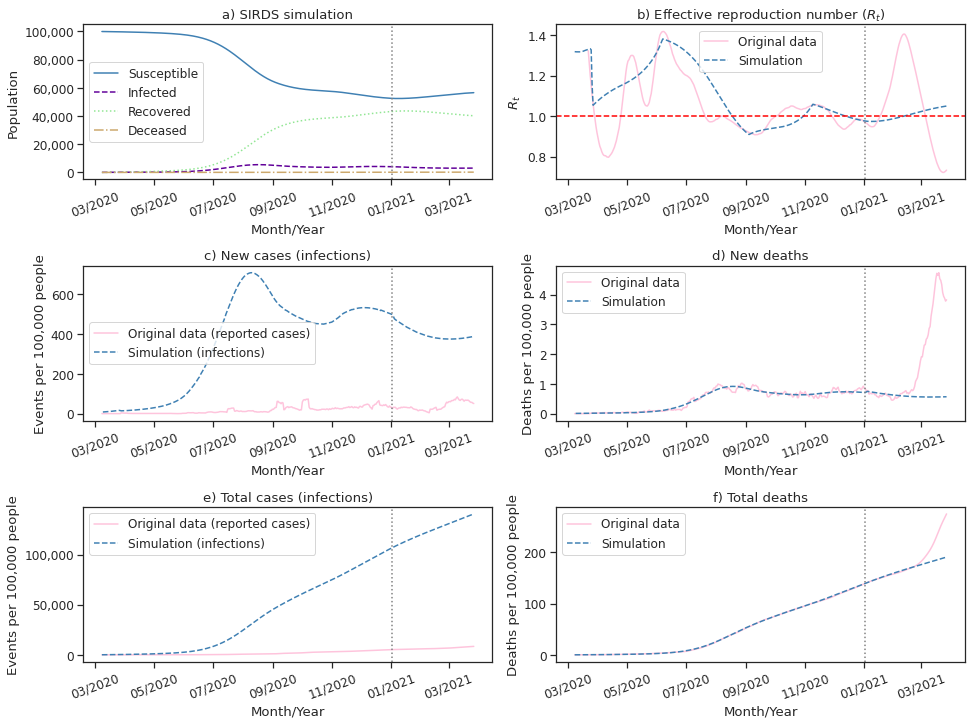

estimated_contact_rate:  0.4316574153999297
Porto Alegre


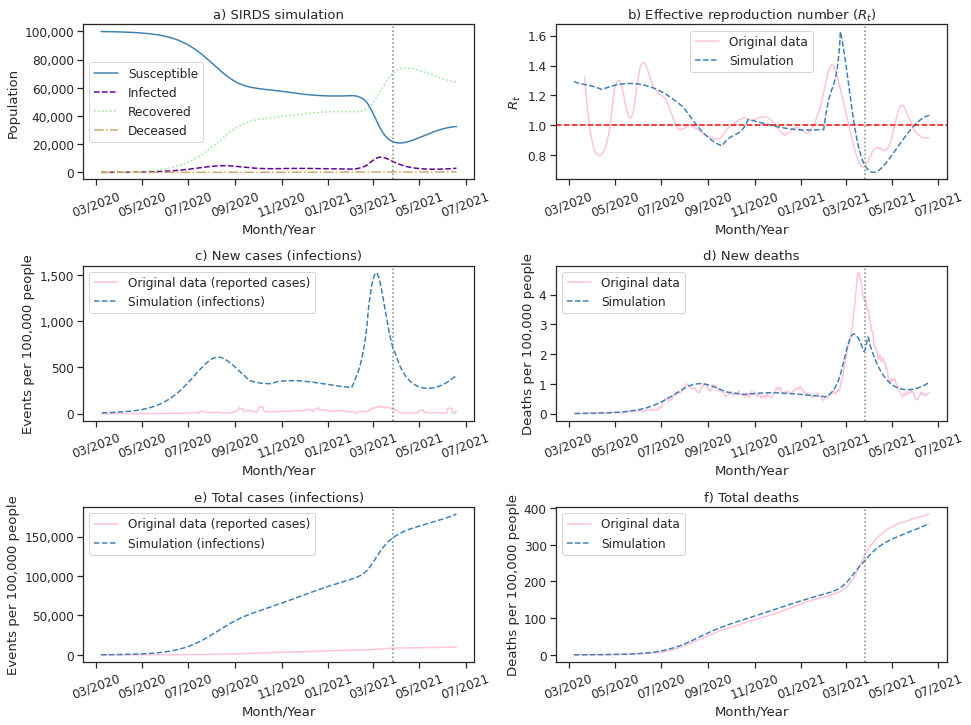

estimated_contact_rate:  0.4097226398084666
Porto Alegre


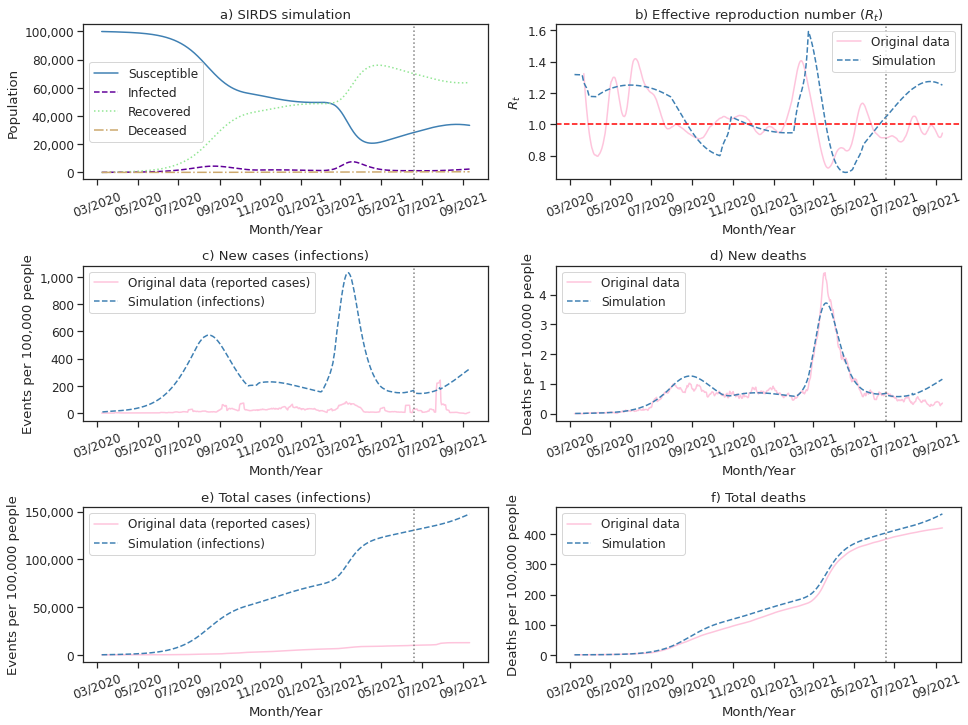

estimated_contact_rate:  None
Porto Alegre


/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


ValueError: All arrays must be of the same length

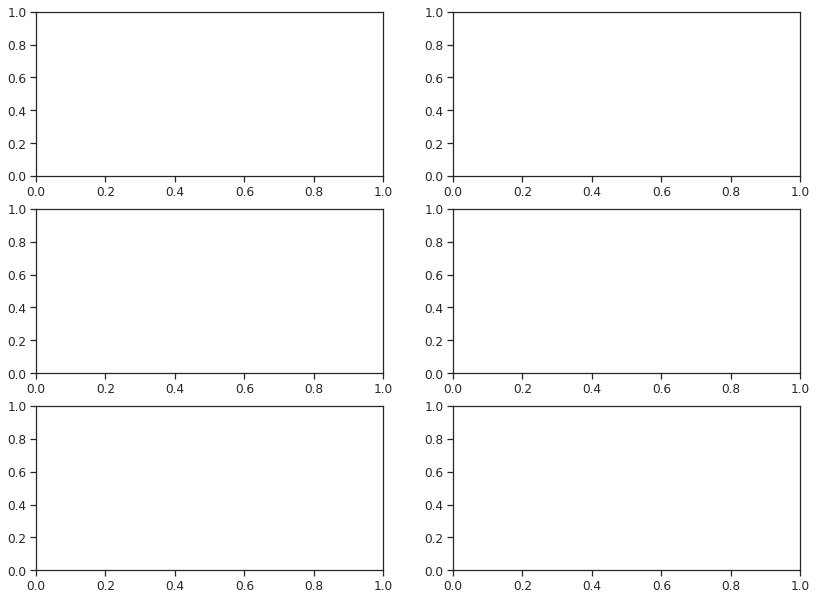

In [41]:
rt_column = 'NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA'

for max_date_to_fit in df_results['max_date_to_fit'].unique():
    df_results_max_data_to_fit = df_results.loc[df_results['max_date_to_fit'] == max_date_to_fit]
    # for id_municipality in df_results_max_data_to_fit.municipality_id.unique():
    for id_municipality in df_results_max_data_to_fit[df_results_max_data_to_fit['municipality']=='Porto Alegre'].municipality_id.unique():        
        df_results_municipality = df_results_max_data_to_fit.loc[df_results_max_data_to_fit.municipality_id == id_municipality]
        df_results_municipality = df_results_municipality[df_results_municipality['result_fun'] == df_results_municipality['result_fun'].min()]
        municipality = df_results_municipality.municipality.iloc[0]
        df_municipality = df[(df.CODIGO_MUNICIPIO_6 == id_municipality)].copy().reset_index(drop=True)    
        population = df_municipality.POPULACAO_2022.loc[0]
    
        for index, result in df_results_municipality.iterrows():
            result = result.dropna()       
            
            estimation = result.estimation
            
            estimated_parameters = df_estimated_parameters.loc[(df_estimated_parameters['municipality_id']==id_municipality) & (df_estimated_parameters['max_date_to_fit']==max_date_to_fit) & (df_estimated_parameters['estimation']==estimation)].iloc[0] 
            estimate_fatality_in_forecast_period = estimated_parameters['estimated_fatality']
            estimated_contact_rate_in_forecast_period = estimated_parameters['estimated_contact_rate']
            if np.isnan(estimated_contact_rate_in_forecast_period):
                estimated_contact_rate_in_forecast_period = None
                estimated_days_between_infections_in_forecast_period = None
            else:
                estimated_days_between_infections_in_forecast_period = 1 / estimated_contact_rate_in_forecast_period                
            print('estimated_contact_rate: ', estimated_contact_rate_in_forecast_period)            
    
            date_first_case = pd.to_datetime(result.date_first_case)
            days_to_recovery = result.days_to_recovery        
            period_in_days_to_fit = int(result.period_in_days)
            period_in_days_general = period_in_days_to_fit + FORECASTING_HORIZON
    
            df_temp = df_municipality[(df_municipality.DATA >= date_first_case)][:period_in_days_general]
            real_new_deaths = df_temp.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS
            real_total_deaths = df_temp.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS.cumsum()
            real_new_cases = df_temp.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS
            real_total_cases = df_temp.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS.cumsum()
            real_reproduction_number = df_temp[rt_column].round(6).values

            y = get_sirds(result, FORECASTING_HORIZON, contact_rate_in_forecast_period=estimated_contact_rate_in_forecast_period, fatality_in_forecast_period=estimate_fatality_in_forecast_period)
            S, I, R, D, I_accumulated = y
            N = S[0] + I[0] + R[0] + D[0]
    
            # print(result)
    
            D_new_deaths, reproduction_number_sird, I_new_cases, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, days_between_infections_values, case_fatality_probability_values, loss_immunity_in_days_values, estimated_days_between_infections, estimated_case_fatality_probability, estimated_loss_immunity_in_days = get_sirds_extras(result, S, D, I_accumulated, forecast_horizon=FORECASTING_HORIZON, estimated_days_between_infections_in_forecast_period=estimated_days_between_infections_in_forecast_period, estimated_fatality_in_forecast_period=estimate_fatality_in_forecast_period)
    
            # show_performance_single(real_new_deaths, D_new_deaths, real_reproduction_number,  reproduction_number_sird) 
            
            print(municipality)
    
            plot_result_single(y, D_new_deaths, real_new_deaths, real_total_deaths, real_reproduction_number, reproduction_number_sird, real_total_cases, real_new_cases, I_new_cases, df_temp.DATA.values, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, days_between_infections_values, days_to_recovery, case_fatality_probability_values, loss_immunity_in_days_values, False, max_date_to_fit=max_date_to_fit)

In [ ]:
df_estimated_parameters.loc[(df_estimated_parameters['municipality_id']==id_municipality)].round(4)            

In [ ]:
df_estimated_parameters.loc[(df_estimated_parameters['municipality_id']==id_municipality) ]